This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

path_prefix = ""

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [2]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=10):

        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=10):
                super(Encoder, self).__init__()
                # needs your implementation
                self.encoderLayer1=nn.Linear(784,1024)
                self.encoderLayer2=nn.Linear(1024,output_size)

            def forward(self, x):
                # needs your implementation
                x = x.view(x.size(0), -1)
                encodeTransforms1= self.encoderLayer1(x)
                encodeTransforms1 =torch.relu(encodeTransforms1)
                #encodeTransforms =torch.sigmoid(encodeTransforms)
                encodeTransforms2= self.encoderLayer2(encodeTransforms1)
                
                return encodeTransforms2

        class Decoder(nn.Module):
            def __init__(self, input_size=10):
                super(Decoder, self).__init__()
                # needs your implementation
                self.decoderLayer1=nn.Linear(input_size,1024)
                self.decoderLayer2=nn.Linear(1024,784)
                

            def forward(self, z):
                # needs your implementation
                decodeTransforms1= self.decoderLayer1(z)
                decodeTransforms1 =torch.relu(decodeTransforms1)
                
                decodeTransforms2= self.decoderLayer2(decodeTransforms1)
                decodeTransforms2 =torch.sigmoid(decodeTransforms2)
                
                decodeTransforms2 = decodeTransforms2.view(-1, 1, 28, 28)
                return decodeTransforms2

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [3]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

autoencoder = Autoencoder(dim_latent_representation=10)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix="./")

## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

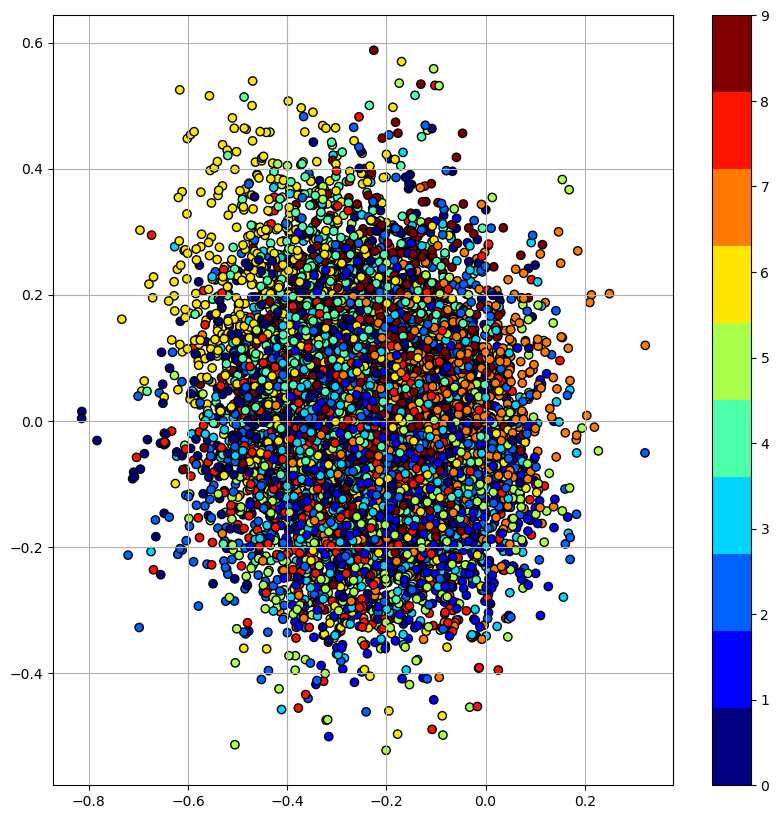

In [4]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from autoencoder_starter import scatter_plot
scatter_plot(latent_representations=z,labels=label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


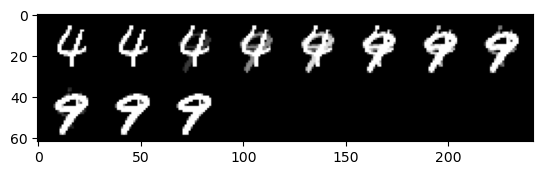

In [5]:
with torch.no_grad():
    samples = torch.randn(7, 10).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

r1 = 9 #torch.randint(0, len(trainer.get_val_set())+1, (1,)).item()
r2 = 109 #torch.randint(0, len(trainer.get_val_set())+1, (1,)).item()
x1 = trainer.get_val_set()[r1]
x1 = x1.view(x1.size(0), -1)
x2 = trainer.get_val_set()[r2]
x2 = x2.view(x2.size(0), -1)

images= []
T = np.arange(0, 1.1, 0.1)
for t in T:
    xt = t*x1+(1-t)*x2
    images.append(xt)

images = torch.vstack(images)

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

Original images


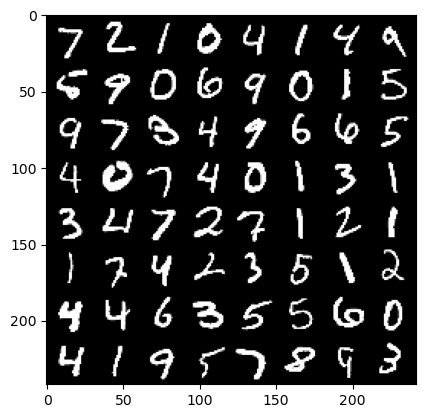

In [6]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


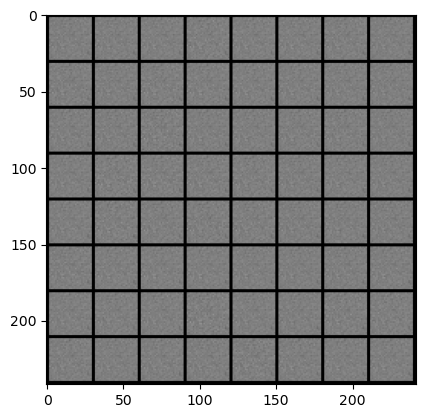

In [7]:
with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)